<a href="https://colab.research.google.com/github/kwanglo/mge51101-20195171/blob/master/mge51101_kwanglo_leNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Skeleton Code for CIFAR dataset

In [12]:
!nvidia-smi
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
print(torch.__version__)

Mon Apr 20 05:09:03 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    33W / 250W |    739MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

## Model - LeNet

In [0]:
#Model Code for LeNet
import torch.nn.functional as F

class MyCNN(nn.Module):
    def __init__(self):
        super(MyCNN, self).__init__()
        #Model Based on LeNet5 
        self.conv1 = nn.Conv2d(3, 6, 5) # input channels, output channels, kernel size
        self.pool = nn.MaxPool2d(2, 2)  # kernel size, stride, padding = 0 (default)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120) # input features, output features
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
    
    def forward(self, inputs):
        inputs= self.pool(F.relu(self.conv1(inputs)))
        inputs = self.pool(F.relu(self.conv2(inputs)))
        inputs = inputs.view(-1, 16 * 5 * 5)
        inputs = F.relu(self.fc1(inputs))
        inputs = F.relu(self.fc2(inputs))
        outputs = self.fc3(inputs)        
        
        return outputs

model = MyCNN().cuda()

# Loss function & Optimizers
"""
you can change the loss and optimizer
"""
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)


# Hyperparameters
"""
you can change the value
"""
num_epochs = 200
batch_size = 128

## Training

Files already downloaded and verified
Files already downloaded and verified

train accuracy: 34.84 %, test accuracy: 45.78 %
epoch:1, train_loss: 1.7711, test_loss: 1.5163

train accuracy: 59.52 %, test accuracy: 62.68 %
epoch:11, train_loss: 1.1455, test_loss: 1.0733

train accuracy: 63.41 %, test accuracy: 65.45 %
epoch:21, train_loss: 1.0357, test_loss: 0.9964

train accuracy: 65.85 %, test accuracy: 67.13 %
epoch:31, train_loss: 0.9677, test_loss: 0.9477

train accuracy: 67.23 %, test accuracy: 69.95 %
epoch:41, train_loss: 0.9308, test_loss: 0.8770

train accuracy: 67.97 %, test accuracy: 70.09 %
epoch:51, train_loss: 0.9022, test_loss: 0.8760

train accuracy: 69.08 %, test accuracy: 70.98 %
epoch:61, train_loss: 0.8812, test_loss: 0.8458

train accuracy: 69.82 %, test accuracy: 72.03 %
epoch:71, train_loss: 0.8565, test_loss: 0.8329

train accuracy: 70.03 %, test accuracy: 72.06 %
epoch:81, train_loss: 0.8533, test_loss: 0.8186

train accuracy: 70.67 %, test accuracy: 72.14 %
epo

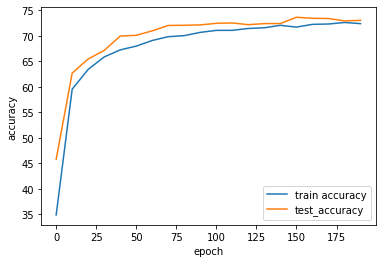

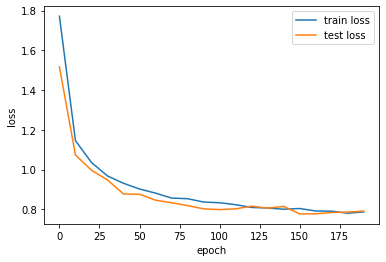

In [17]:
import sys
sys.path.insert(0, "..")
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms

# CIFAR preprocessing 
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# DataLoader for CIFAR-10
cifar_train = torchvision.datasets.CIFAR10(root="./", 
                                         train=True, 
                                         download=True,
                                         transform=transform_train
                                         )
cifar_test = torchvision.datasets.CIFAR10(root="./", 
                                        train=False, 
                                        download=True,
                                        transform=transform_test)


train_loader = DataLoader(cifar_train, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader = DataLoader(cifar_test, batch_size=batch_size, shuffle=False, num_workers=4)

 
accuracy_graph = {'train':[], 'test':[], 'epoch': []}
loss_graph = {'train':[], 'test':[], 'epoch': []}

class accumulator():
    def __init__(self):
        self.cnt = 0
        self.obs = 0
        self.loss = 0

    def add(self, predict, output):

        assert len(predict) == len(output)

        self.cnt += self.count(predict, output).cpu().numpy()
        self.obs += len(predict)
    
    def count(self, predict, output):
        correct = torch.sum(torch.argmax(predict, dim=1) == output)
        
        return correct
        
    def loss_update(self, loss, batch_size):
        self.loss += loss * batch_size

    def running_stat(self):
        if self.obs != 0:
            run_acc = 100 * self.cnt / self.obs
            run_loss = self.loss / self.obs
        else: 
            run_acc = 0
            rum_loss = 0

        return run_acc, run_loss

    def reset(self):
        self.__init__()


for epoch in range(num_epochs):

    train_accuracy = accumulator()
    test_accuracy = accumulator()

    # Training
    for train_x, train_y in train_loader: 

        train_x, train_y = train_x.cuda(), train_y.cuda()
        train_predict = model(train_x)
        loss = criterion(train_predict, train_y)

        # Backpropagation        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_accuracy.add(train_predict, train_y)
        train_accuracy.loss_update(loss, batch_size)

    # Evaluation
    if epoch % 10 ==0:
             
        for test_x, test_y in test_loader:

            with torch.autograd.no_grad():
                test_x, test_y = test_x.cuda(), test_y.cuda()
                test_predict = model(test_x)
                test_accuracy.add(test_predict, test_y)

            loss_test = criterion(test_predict, test_y)
            test_accuracy.loss_update(loss_test, batch_size)

        train_acc, train_loss = train_accuracy.running_stat()
        test_acc, test_loss = test_accuracy.running_stat()
        accuracy_graph['train'].append(train_acc)
        accuracy_graph['test'].append(test_acc) 
        accuracy_graph['epoch'].append(epoch)
        loss_graph['train'].append(train_loss)
        loss_graph['test'].append(test_loss)
        loss_graph['epoch'].append(epoch)
        
        print("\ntrain accuracy: {:.2f} %, test accuracy: {:.2f} %".format(train_acc, test_acc))
        print("epoch:{}, train_loss: {:.4f}, test_loss: {:.4f}".format(epoch+1, train_loss, test_loss)) 

        train_accuracy.reset(), test_accuracy.reset()


plt.plot(accuracy_graph['epoch'], accuracy_graph['train'], label = "train accuracy");
plt.plot(accuracy_graph['epoch'], accuracy_graph['test'], label = "test_accuracy");
plt.legend()
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.show()

plot_loss_train = plt.plot(loss_graph['epoch'], loss_graph['train'], label="train loss");
plt.plot(loss_graph['epoch'], loss_graph['test'], label="test loss");
plt.legend()
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()